# Demo

Case 2: Train with complete dataset and test with complete dataset (the imputed dataset, >50% is omitted)

FCNN (fully connected neural network) with 1D-CNN for dimensionality reduction for field data

Input (global mean imputed well properties), Output (multi-dimensional latent variables)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set_style("whitegrid")

import warnings
warnings.filterwarnings("ignore")

import dataloader2
import models
import util

# Display input and output data

In [2]:
#load dataset
data = dataloader2.DataLoader(verbose=False)
x_train, x_test, y_train, y_test, cumm_train, cumm_test = data.get_split(use_complete_data_only=True)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)
print(cumm_train.shape, cumm_test.shape)

(200, 5) (153, 5) (200, 60, 3) (153, 60, 3)
(200, 3) (153, 3)


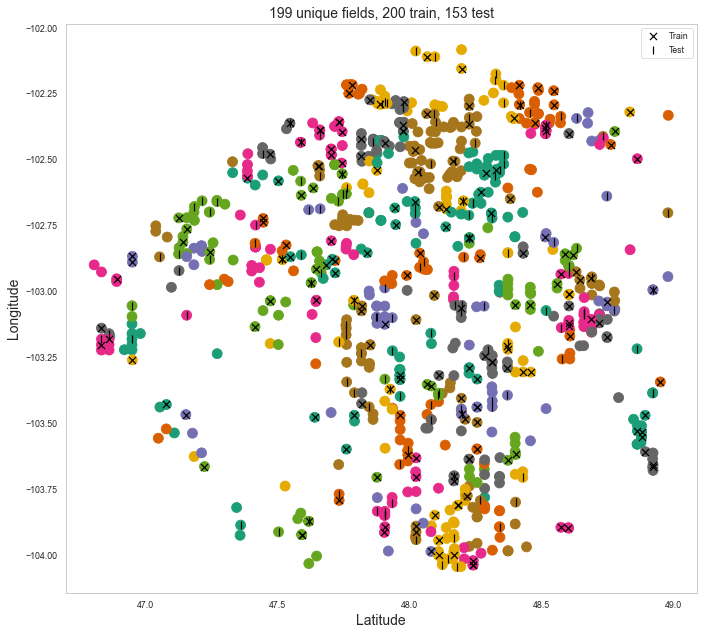

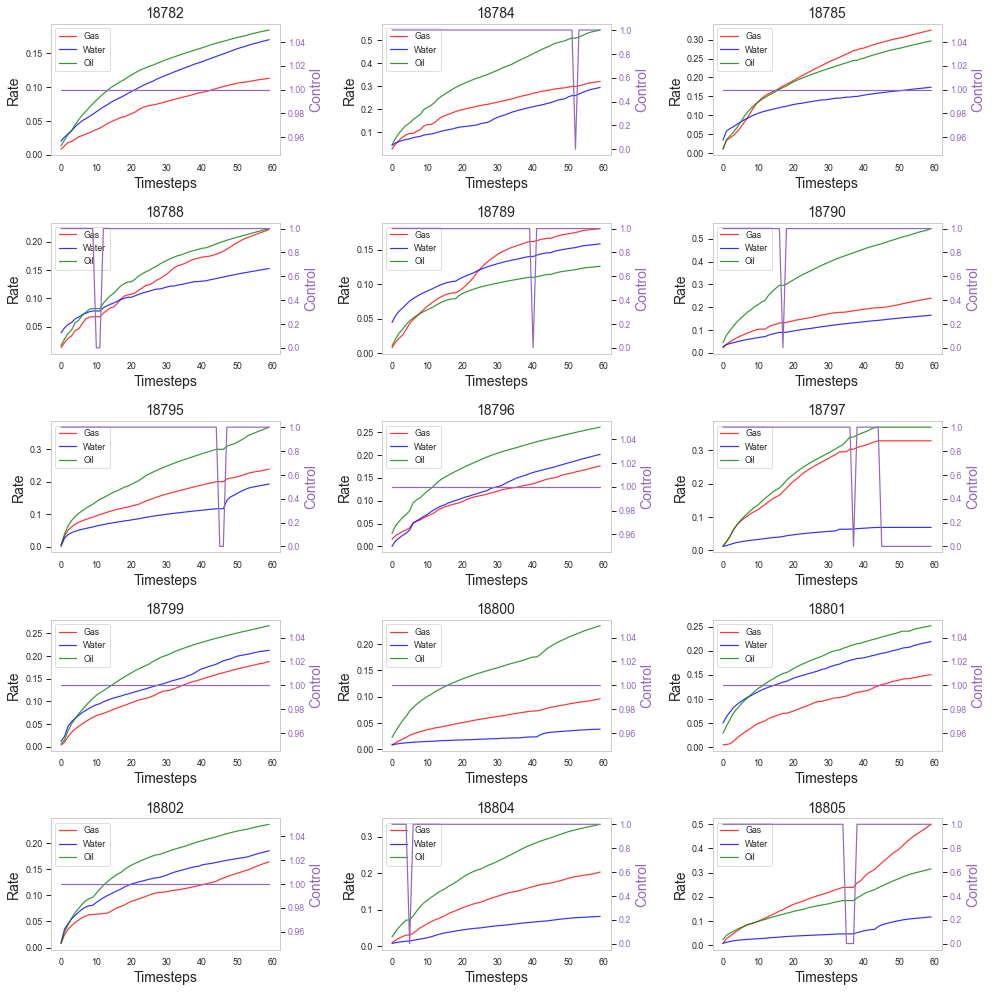

In [3]:
#visualize field and sample wells
data.plot_fields()
data.plot_wells()

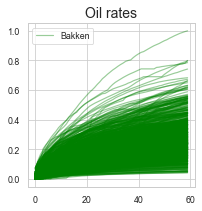

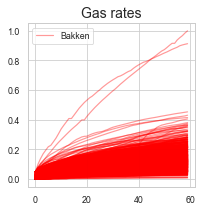

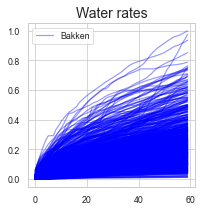

In [4]:
#visualize the ranges of output data
data.plot_data_by_phase()

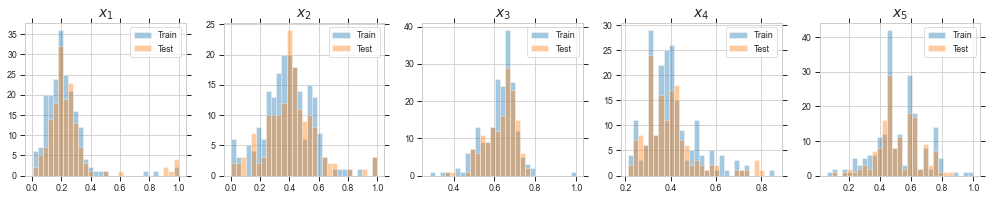

In [5]:
#visualize the ranges of input data
dataloader2.histplot(x_train, x_test)

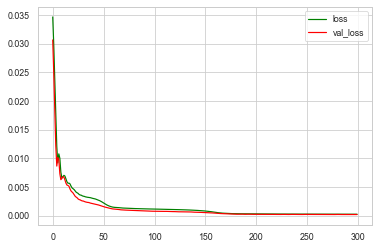

In [6]:
#reduce dimension of data

z_dim = 3
data_ae = models.models(name = 'data_ae',
                          z_dim = z_dim, 
                          timesteps = y_train.shape[1], 
                          n_features = y_train.shape[-1])

data_ae.train_autoencoder1D(y_train, load = False, epoch=300)

In [7]:
#qc reconstruction quality
y_train_hat = data_ae.d2d.predict(y_train)
y_test_hat = data_ae.d2d.predict(y_test)

z_y_train = data_ae.d2zd.predict(y_train)
z_y_test = data_ae.d2zd.predict(y_test)

0.007264270422771892
0.008166844649399678


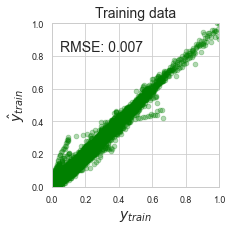

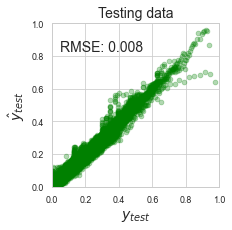

In [8]:
def RMSE(data1, data2):
    return np.sqrt(np.mean((data1.flatten()-data2.flatten())**2)) /2

from sklearn.metrics import r2_score

#scatter plots for training and testing, color by field label
def scatterPlot(data1, data2, xlabel, ylabel, title, limits=True, limits_custom=False, score=False, c=None):
    fig, ax = plt.subplots(figsize=(3, 3))
    if c is None:
        plt.scatter(data1, data2, c='g', alpha=0.3)
    else:
        plt.scatter(data1, data2, c=c, alpha=0.9, cmap="seismic")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if limits:
        plt.xlim([0, 1])
        plt.ylim([0, 1])
    if limits_custom:
        plt.xlim([np.min(data1), np.max(data1)])
        plt.ylim([np.min(data1), np.max(data1)])
    plt.title(title)
    if score:
        #ax.annotate(f"R2: {r2_score(data1.flatten(), data2.flatten()):.3f}", xy=(0.8, 0.8),  xycoords='data',
        #        xytext=(0.05, 0.9), textcoords='axes fraction',
        #        horizontalalignment='left', verticalalignment='top')
        ax.annotate(f"RMSE: {RMSE(data1, data2):.3f}", xy=(0.8, 0.8),  xycoords='data',
                xytext=(0.05, 0.9), textcoords='axes fraction',
                horizontalalignment='left', verticalalignment='top')
        print(RMSE(data1, data2))
    
scatterPlot(y_train, y_train_hat, '$y_{train}$', '$\hat{y}_{train}$', 'Training data', score=True)
scatterPlot(y_test, y_test_hat, '$y_{test}$', '$\hat{y}_{test}$', 'Testing data', score=True)

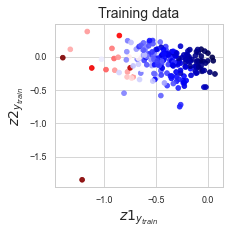

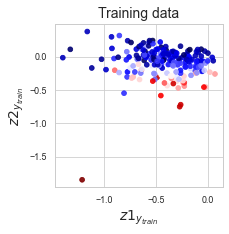

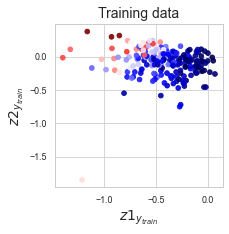

In [9]:
#display latent space with cumm oil production
scatterPlot(z_y_train[:, 0], z_y_train[:, 1], '$z1_{y_{train}}$', '$z2_{y_{train}}$', 'Training data', limits=False, c=cumm_train[:,0])
scatterPlot(z_y_train[:, 0], z_y_train[:, 1], '$z1_{y_{train}}$', '$z2_{y_{train}}$', 'Training data', limits=False, c=cumm_train[:,1])
scatterPlot(z_y_train[:, 0], z_y_train[:, 1], '$z1_{y_{train}}$', '$z2_{y_{train}}$', 'Training data', limits=False, c=cumm_train[:,2])

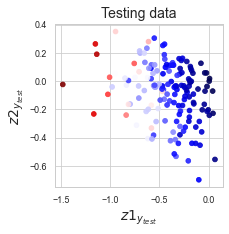

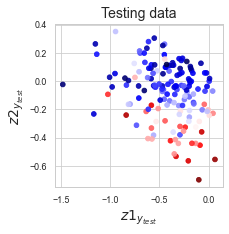

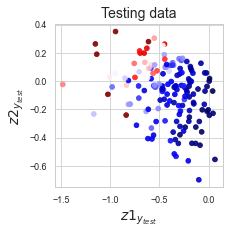

In [10]:
#display latent space with cumm oil production
scatterPlot(z_y_test[:, 0], z_y_test[:, 1], '$z1_{y_{test}}$', '$z2_{y_{test}}$', 'Testing data', limits=False, c=cumm_test[:,0])
scatterPlot(z_y_test[:, 0], z_y_test[:, 1], '$z1_{y_{test}}$', '$z2_{y_{test}}$', 'Testing data', limits=False, c=cumm_test[:,1])
scatterPlot(z_y_test[:, 0], z_y_test[:, 1], '$z1_{y_{test}}$', '$z2_{y_{test}}$', 'Testing data', limits=False, c=cumm_test[:,2])

# FCNN 

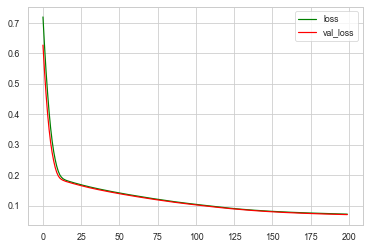

In [11]:
#data
print(z_y_train.shape, z_y_test.shape)

#create fcnn model 
fcnn = models.fcnn(name = 'fcnn',
                          z_dim = z_y_train.shape[-1], 
                          x_dim = x_train.shape[-1])

fcnn.train_fcnn(x_train, z_y_train, load = False, epoch=200)

(200, 3) (153, 3)
0.13380952179431915
0.13458062708377838


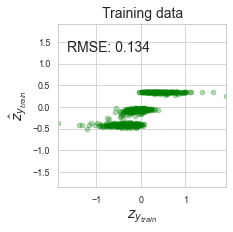

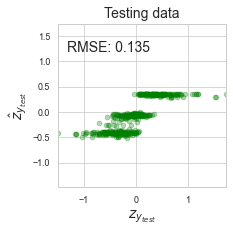

In [12]:
#get predictions
z_y_train_hat = fcnn.x2zd.predict(x_train)
z_y_test_hat = fcnn.x2zd.predict(x_test)

print(z_y_train_hat.shape, z_y_test_hat.shape)


scatterPlot(z_y_train, z_y_train_hat, '$z_{y_{train}}$', '$\hat{z}_{y_{train}}$', 'Training data', limits=False, limits_custom=True, score=True)
scatterPlot(z_y_test, z_y_test_hat, '$z_{y_{test}}$', '$\hat{z}_{y_{test}}$', 'Testing data', limits=False, limits_custom=True, score=True)

In [13]:
#plot prediction profile vs reference profile
y_test_hat_pred = data_ae.zd2d.predict(z_y_test_hat)
y_train_hat_pred = data_ae.zd2d.predict(z_y_train_hat)

#predicted from latent space
print(y_test_hat_pred.shape)
#reconstructed from autoencoder
print(y_test_hat.shape)
#actual simulated profile
print(y_test.shape)

(153, 60, 3)
(153, 60, 3)
(153, 60, 3)


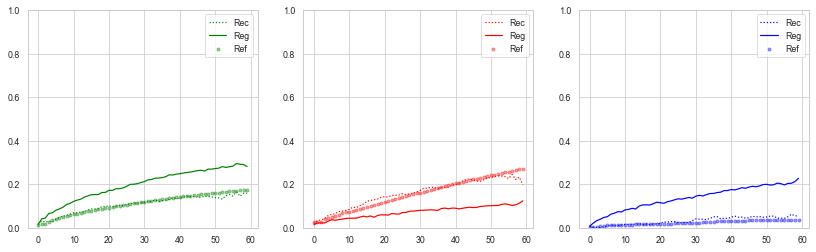

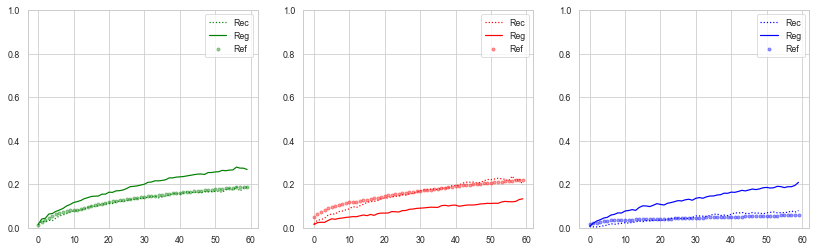

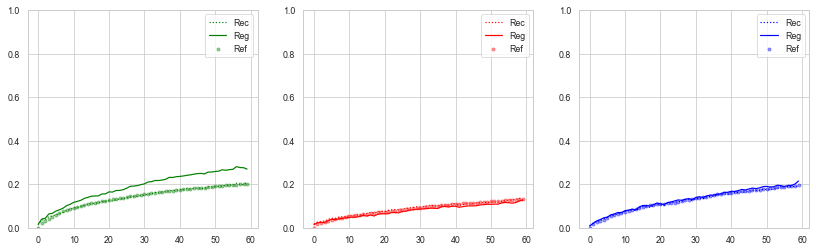

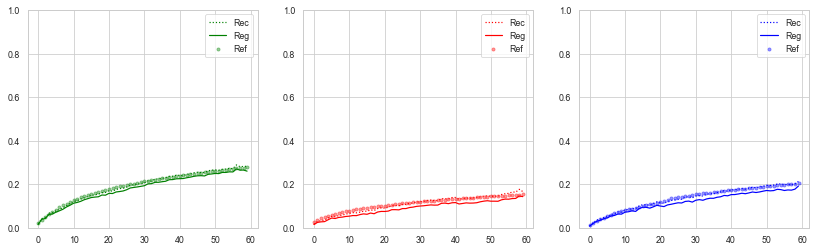

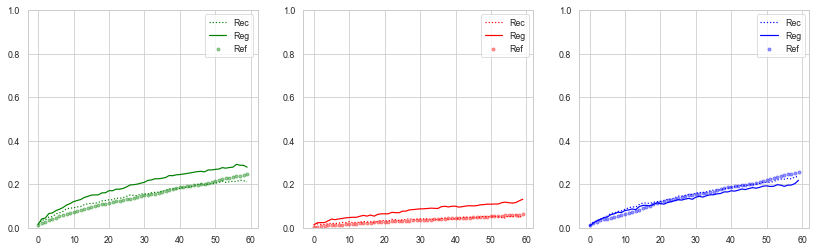

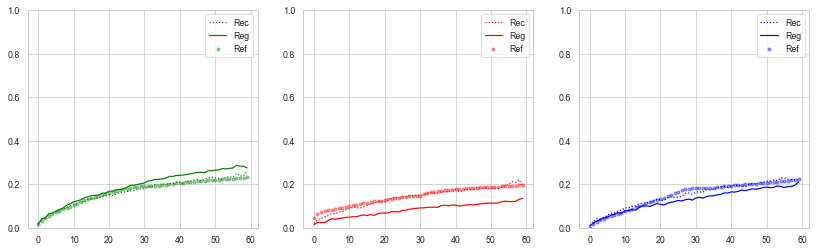

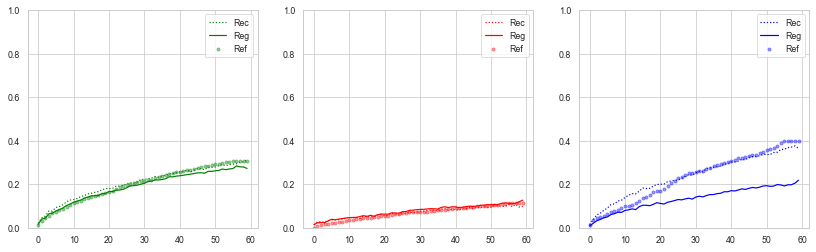

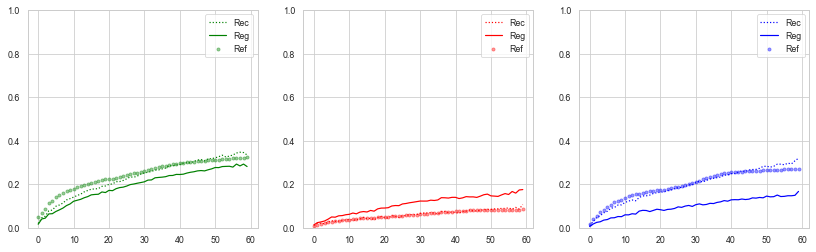

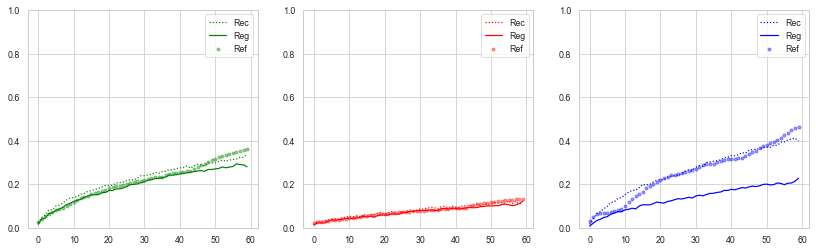

In [14]:
#compare some production profiles
def compareProfiles(well_idx, data_ref, data_recon, data_reg):

    timesteps = np.linspace(0, data_ref.shape[1]-1, data_ref.shape[1])
    plt.figure(figsize=[14, 4])
    plt.subplot(1, 3, 1)
    plt.scatter(timesteps, data_ref[well_idx, :, 0], c='green', s=10, alpha=0.4, label='Ref')
    plt.plot(timesteps, data_recon[well_idx, :, 0], c='green', ls=':',  label='Rec')
    plt.plot(timesteps, data_reg[well_idx, :, 0], c='green', label='Reg')
    plt.ylim([0, 1])
    plt.legend()
    
    plt.subplot(1, 3, 2)
    plt.scatter(timesteps, data_ref[well_idx, :, 1], c='red', s=10, alpha=0.4, label='Ref')
    plt.plot(timesteps, data_recon[well_idx, :, 1], c='red', ls=':', label='Rec')
    plt.plot(timesteps, data_reg[well_idx, :, 1], c='red', label='Reg')
    plt.ylim([0, 1])
    plt.legend()
    
    plt.subplot(1, 3, 3)
    plt.scatter(timesteps, data_ref[well_idx, :, 2], c='blue', s=10, alpha=0.4, label='Ref')
    plt.plot(timesteps, data_recon[well_idx, :, 2], c='blue', ls=':', label='Rec')
    plt.plot(timesteps, data_reg[well_idx, :, 2], c='blue', label='Reg')
    plt.ylim([0, 1])
    plt.legend()
    
#plot for some cases
cases = [0, 3, 4, 5, 6, 7, 8, 9, 10]
for case in cases:
    compareProfiles(case, y_test, y_test_hat, y_test_hat_pred)

0.046777872056972175
0.04742893025973912


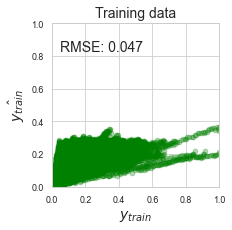

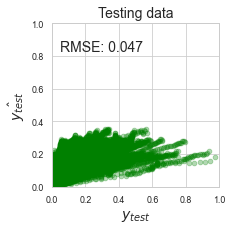

In [15]:
scatterPlot(y_train[:, :], y_train_hat_pred[:, :], '$y_{train}$', '$\hat{y_{train}}$', 'Training data', limits=True, score=True)
scatterPlot(y_test[:, :], y_test_hat_pred[:, :], '$y_{test}$', '$\hat{y_{test}}$', 'Testing data', limits=True, score=True)